In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time

## Step 1: Define Helper Functions

In [2]:
# csv_files_2017 = [('2017' + "%.2d" + '-citibike-tripdata.csv') % i for i in range(1, 13)]
# csv_files_2018 = [('2018' + "%.2d" + '-citibike-tripdata.csv') % i for i in range(1, 13)]
# csv_files_2019 = [('2019' + "%.2d" + '-citibike-tripdata.csv') % i for i in range(1, 13)]
# csv_files = csv_files_2017 + csv_files_2018 + csv_files_2019

In [3]:
# months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [4]:
def to_datetime(df):
    df1 = df.copy()
    df1['starttime'] = pd.to_datetime(df1['starttime'])
    df1['stoptime'] = pd.to_datetime(df1['stoptime'])
    df1['start_date'] = df1['starttime'].dt.date
    df1['start_time'] = df1['starttime'].dt.time
    df1['start_hour'] = df1['starttime'].dt.hour
    df1['start_min'] = df1['starttime'].dt.minute
    df1['start_year'] = df1['starttime'].dt.year
    df1['start_month'] = df1['starttime'].dt.month
    df1['start_dayofweek'] = df1['starttime'].dt.weekday   # Monday is 0, Sunday is 6
    #df1['start_dayofweek'] = df1['starttime'].dt.weekday_name  # The name of day in a week (e.g. Monday)
    df1['stop_date'] = df1['stoptime'].dt.date
    df1['stop_time'] = df1['stoptime'].dt.time
    df1['stop_hour'] = df1['stoptime'].dt.hour
    df1['stop_min'] = df1['stoptime'].dt.minute
    df1['stop_dayofweek'] = df1['stoptime'].dt.weekday
    return df1

In [5]:
def ignore_offpeak(df):
    df1 = df.copy()
    mask = df1['start_hour'].apply(lambda x: 5 <= x <= 20)
    return df1[mask]

In [6]:
def aggregated_data(df):
    # Calculate daily trip counts, avg trip duration, and avg trip distance and merge to original df
    # Method 1: use long and lat to estimate distance travelled 
#     log_diff = df['end_station_longitude']-df['start_station_longitude']
#     lat_diff = df['end_station_latitude']-df['start_station_latitude']
#     df['distance'] = abs(log_diff)*53 + abs(lat_diff)*69
    # Method 2: Naive way of estimating distance based on an average speed of 7.456 mph
    df['distance'] = df['trip_duration']*7.456/3600
    df_daily = df.groupby('start_date').agg({'trip_duration':['count','mean'],'distance':'mean'}).reset_index()
    df_daily.columns = ['start_date','trip_per_day','daily_avg_trip_duration','daily_avg_distance']
    df_daily_merged = df.merge(df_daily, how = 'left', on = 'start_date')
    # Calculate hourly trip counts, avg trip duration, and avg trip distance per station and merge to above df
    df_hourly = df_daily_merged.groupby(['start_station_ID','start_date','start_hour']).\
    agg({'trip_duration':['count','mean'],'distance':'mean'}).reset_index()
    df_hourly.columns = ['start_station_ID','start_date','start_hour','trip_per_hour','hourly_avg_trip_duration','hourly_avg_distance']
    df_hourly_merged = df_daily_merged.merge(df_hourly, how = 'left', on = ['start_station_ID','start_date','start_hour'])
    return df_hourly_merged    

In [7]:
def merge_bikecount(df):
    # groupby start station ID, date and hour to get hourly counts of trips per start station
    checkout = df.groupby(['start_station_ID','start_date','start_hour'])['trip_duration'].count().reset_index()
    checkout.columns = ['start_station_ID','start_date','start_hour','checkout_counts']
    # groupby end station ID, date, and hour to get hourly counts of trips per end station 
    checkin = df.groupby(['end_station_ID','stop_date','stop_hour'])[['trip_duration']].count().reset_index()
    checkin.columns=['end_station_ID','stop_date','stop_hour','checkin_counts']
    # Join dataframe to get station checkin and checkout counts 
    temp = pd.merge(checkout, checkin,  how='outer', left_on=['start_station_ID','start_date','start_hour'], 
                    right_on = ['end_station_ID','stop_date','stop_hour'])
    temp['start_station_ID'] = temp['start_station_ID'].fillna(temp['end_station_ID'])
    temp['start_date'] = temp['start_date'].fillna(temp['stop_date'])
    temp['start_hour'] = temp['start_hour'].fillna(temp['stop_hour'])
    temp['checkout_counts'] = temp['checkout_counts'].fillna(0)
    temp['checkin_counts'] = temp['checkin_counts'].fillna(0)
    temp = temp.drop(['end_station_ID','stop_date','stop_hour'],axis=1)
    temp.columns=['station_ID','date','hour','checkout_counts','checkin_counts']
    temp['bike_added'] = temp['checkin_counts'] - temp['checkout_counts']
    # merge orginal dataframe to get hourly checkin/checkout information for both start and stop stations 
    df_temp_merged = pd.merge(df, temp,  how='left', left_on=['start_station_ID','start_date','start_hour'], 
         right_on = ['station_ID','date','hour']).drop(['station_ID','date','hour'],axis = 1)
    df_temp_merged = pd.merge(df_temp_merged, temp,  how='left', left_on=['end_station_ID','stop_date','stop_hour'], 
         right_on = ['station_ID','date','hour']).drop(['station_ID','date','hour'],axis = 1) 
    df_temp_merged = df_temp_merged.rename(columns={'checkout_counts_x':'start_station_checkout_counts',
                                                    'checkin_counts_x':'start_station_checkin_counts',
                                                    'bike_added_x':'start_station_bike_added', 
                                                    'checkout_counts_y':'end_station_checkout_counts',
                                                    'checkin_counts_y':'end_station_checkin_counts',
                                                    'bike_added_y':'end_station_bike_added'}) 
    return df_temp_merged
    

## Merge Datasets

In [8]:
# total_time = 0
# for i, csv in enumerate(csv_files):
#     start_time = time.time()
#     df_temp = pd.read_csv('../Tripdata/'+csv)
#     df_temp.columns = ['trip_duration','starttime','stoptime','start_station_ID','start_station_name',
#                        'start_station_latitude','start_station_longitude','end_station_ID','end_station_name',
#                        'end_station_latitude','end_station_longitude','bike_ID','user_type','birth_year','gender']
#     df_temp = to_datetime(df_temp)
#     df_temp = ignore_offpeak(df_temp)
#     df_temp = aggregated_data(df_temp)
#     # Take a 5% subset of the monthly file as training dataset
#     df_validate, df_train = train_test_split(merge_bikecount(df_temp), test_size=0.05, random_state=42 )
#     # Take a 5% of the validate data set as test dataset
#     df_notused, df_test = train_test_split(df_validate, test_size=0.05, random_state=42 )
#     df_train.to_csv(months[i%12] + csv[:4] + 'train.csv')
#     df_test.to_csv(months[i%12] + csv[:4] + 'test.csv')
#     print('Finishing data extraction from ' + csv)
#     timeSpent = time.time() - start_time
#     print('This iteration uses %.2f'%(timeSpent))
#     total_time += timeSpent

In [9]:
# train_list = []
# test_list = []
# for i, csv in enumerate(csv_files):
#     train_list.append(months[i%12] + csv[:4] + 'train.csv')
#     test_list.append(months[i%12] + csv[:4] + 'test.csv')

In [10]:
# Merge all months train.csv into one train dataframe
# train_df = pd.DataFrame()
# for i in range(len(train_list)):
#     temp_df = pd.read_csv(train_list[i], index_col = 0)
#     train_df = pd.concat([train_df, temp_df], axis = 0)
#     print('Finished ' + str(i) + ' element')
# train_df.to_csv('train.csv')

In [11]:
# Merge all months test.csv into one test dataframe
# test_df = pd.DataFrame()
# for i in range(len(test_list)):
#     temp_df = pd.read_csv(test_list[i], index_col = 0)
#     test_df = pd.concat([test_df, temp_df], axis = 0)
#     print('Finished ' + str(i) + ' element')
# test_df.to_csv('test.csv')

In [12]:
# train_df = pd.read_csv('train.csv', index_col = 0)

In [13]:
# test_df = pd.read_csv('test.csv', index_col = 0)

### Merge Weather Dataset

In [14]:
# weather = pd.read_csv('weather.csv',index_col = 0).reset_index()
# weather = weather.fillna(0)
# weather['DATE'] = pd.to_datetime(weather['DATE'])
# weather['TAVG'] = (weather['TMIN']+weather['TMAX'])/2
# weather['HasPRCP'] = [1 if x !=0 else 0 for x in weather['PRCP']]
# weather['HasSNOW'] = [1 if x !=0 else 0 for x in weather['SNOW']]

In [15]:
# weather

In [16]:
# train_df['start_date'] = pd.to_datetime(train_df['start_date'])
# train_df_weather = train_df.merge(weather,how='left',
#                                   left_on = 'start_date', right_on = 'DATE').drop(['DATE'],axis=1)

In [17]:
# test_df['start_date'] = pd.to_datetime(test_df['start_date'])
# test_df_weather = test_df.merge(weather,how='left',
#                                   left_on = 'start_date', right_on = 'DATE').drop(['DATE'],axis=1)

In [18]:
# train_df_weather.to_csv('train_weather.csv')
# test_df_weather.to_csv('test_weather.csv')

### Load Merged Dataset

In [19]:
train_df_weather = pd.read_csv('train_weather.csv',index_col = 0)
test_df_weather = pd.read_csv('test_weather.csv',index_col = 0)

C:\Users\zhang\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


### Seasonal Trend 

In [20]:
# Time Series of Trip Count
daily_trip = train_df_weather[['start_date','trip_per_day','daily_avg_trip_duration','daily_avg_distance']].sort_values(by='start_date')
daily_trip.columns = ['Date','Daily Trip Count','Avg Trip Duration','Avg Distance']
daily_trip = daily_trip.groupby('Date').agg('mean').reset_index().set_index('Date')
daily_trip

,Daily Trip Count,Avg Trip Duration,Avg Distance
Date,,,
2017-01-01,13594,1194.615860,2.474182
2017-01-02,7753,699.582484,1.448913
2017-01-03,13070,1023.747131,2.120294
2017-01-04,32140,775.994742,1.607171
2017-01-05,26518,668.034920,1.383575
...,...,...,...
2019-12-27,28831,986.114391,2.042352
2019-12-28,25378,1074.806289,2.226043
2019-12-29,16182,1144.572921,2.370538


Text(0, 0.5, 'Avg Distance(mile)')

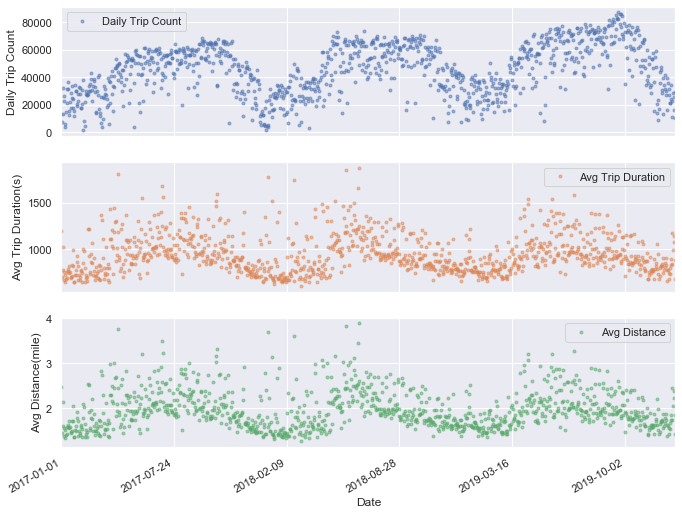

In [21]:
sns.set(rc={'figure.figsize':(11, 4)})
cols_plot = ['Daily Trip Count','Avg Trip Duration','Avg Distance']
axes = daily_trip[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
axes[0].set_ylabel('Daily Trip Count')
axes[1].set_ylabel('Avg Trip Duration(s)')
axes[2].set_ylabel('Avg Distance(mile)')

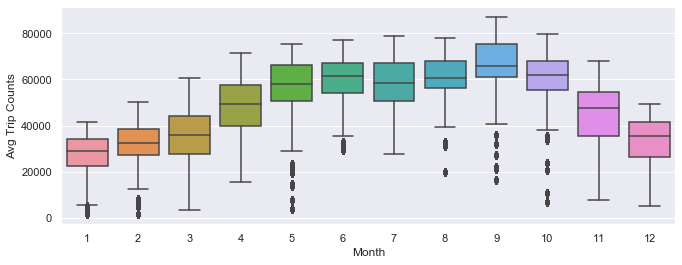

In [22]:
# Trip counts by month
month_trip = train_df_weather[['start_month','trip_per_day','daily_avg_trip_duration','daily_avg_distance']].sort_values(by='start_month')
month_trip.columns=['Month','Avg Trip Counts','Avg Trip Duration','Avg Distance'] 
sns.boxplot(x="Month", y="Avg Trip Counts", data=month_trip)

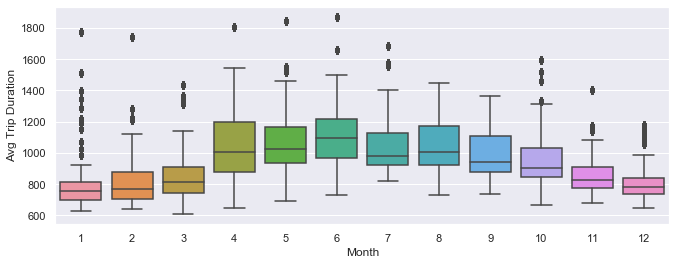

In [23]:
# Trip Duration by Month
sns.boxplot(x="Month", y="Avg Trip Duration",  data=month_trip)

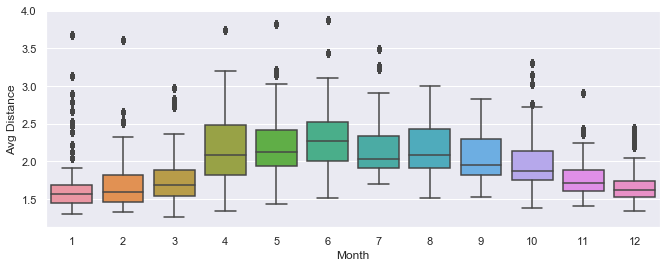

In [24]:
# Trip distance by Month
sns.boxplot(x="Month", y="Avg Distance", data=month_trip)

In [25]:
# sns.distplot(train_df.starttime)

### Top 20 Stations with highest counts 

In [26]:
# group by the dock station
train_df_weather.groupby(['start_station_name']).count()[['trip_duration']].\
sort_values(by = 'trip_duration', ascending = False).head(20)

,trip_duration
start_station_name,
Pershing Square North,22274
E 17 St & Broadway,16055
Broadway & E 22 St,15604
W 21 St & 6 Ave,15123
West St & Chambers St,14540
8 Ave & W 31 St,13697
Broadway & E 14 St,12848
12 Ave & W 40 St,12678
8 Ave & W 33 St,12452


### Peak hours 

In [27]:
# Group by the start_hour and see the frequency correspond to each starting hour
train_df_weather.groupby('start_hour').count()[['trip_duration']].sort_values(by = 'trip_duration', ascending = False)

,trip_duration
start_hour,
17,266935
18,253655
8,217026
16,193315
19,176140
9,171874
15,166931
14,158987
13,154796


In [28]:
train_df_weather.loc[train_df_weather.distance > 10].sort_values(by = 'trip_duration', ascending = False).\
head(20)[['trip_duration', 'starttime', 'stoptime', 'user_type', 'distance']]

,trip_duration,starttime,stoptime,user_type,distance
790733,8096462,2018-02-25 17:06:26.182,2018-05-30 11:07:28.577,Customer,16768.672409
1033792,5891578,2018-06-02 13:13:38.597,2018-08-09 17:46:37.272,Customer,12202.112658
210128,5363062,2017-05-04 15:49:08,2017-07-05 17:33:30,Customer,11107.497298
980106,4602582,2018-05-26 16:42:01.421,2018-07-18 23:11:43.765,Customer,9532.458720
176137,4318433,2017-05-28 16:55:31,2017-07-17 16:29:25,Subscriber,8943.954569
589145,3897730,2017-10-12 15:16:31,2017-11-26 16:58:41,Customer,8072.631911
866420,3653986,2018-04-26 18:27:22.296,2018-06-08 01:27:09.083,Customer,7567.811004
1024611,3553060,2018-06-18 19:32:57.135,2018-07-29 22:30:37.590,Customer,7358.782044
2143411,3341929,2019-08-05 19:53:13.655,2019-09-13 12:12:02.969,Customer,6921.506284
634393,3274876,2017-10-25 16:17:46,2017-12-02 12:59:03,Customer,6782.632071


In [29]:
train_df_weather.loc[(train_df_weather.distance > 10) & (train_df_weather.user_type == 'Subscriber')].shape[0]/\
train_df_weather.loc[(train_df_weather.distance > 10)].shape[0]

0.25863274150705995

In [30]:
14306/2479389

0.005769969940174777

In [31]:
train_df_weather.loc[train_df_weather.user_type == 'Subscriber'].shape[0]/train_df_weather.shape[0]

0.8786289686692972

In [32]:
train_df_weather.loc[train_df_weather.user_type != 'Subscriber'].shape[0]/train_df_weather.shape[0]

0.12137103133070284

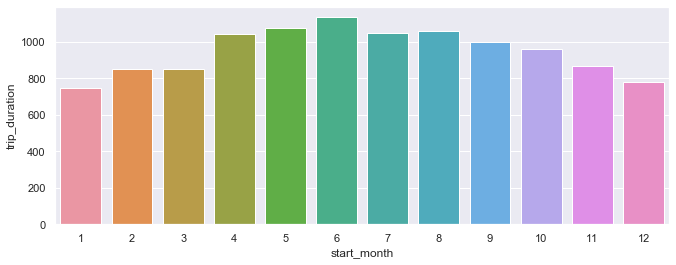

In [33]:
a = train_df_weather.groupby('start_month').mean()[['trip_duration']].reset_index()
sns.barplot(x = a.start_month, y = a.trip_duration)

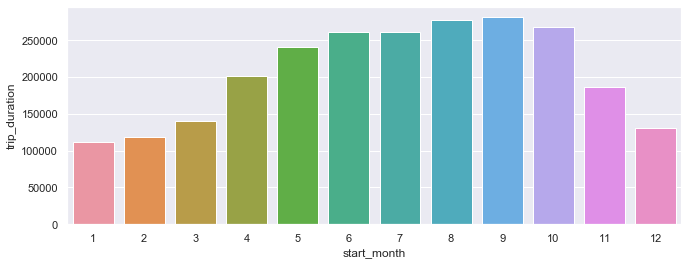

In [34]:
b = train_df_weather.groupby('start_month').count()[['trip_duration']].reset_index()
sns.barplot(x = b.start_month, y = b.trip_duration)

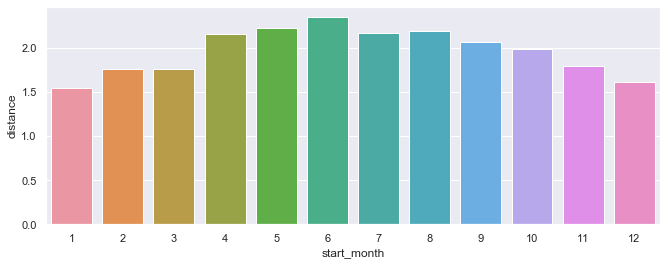

In [35]:
c = train_df_weather.groupby('start_month').mean()[['distance']].reset_index()
sns.barplot(x = c.start_month, y = c.distance)

### Weather Impact